In [1]:
# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu


In [2]:
from dLuxToliman import AlphaCen, TolimanOpticalSystem, ApplyBasisCLIMB

# Construct source
source = AlphaCen()

# Optimisable binary mask
climb_basis = np.load("files/basis.npy")
coefficients = 100*jr.normal(jr.PRNGKey(0), [len(climb_basis)])
mean_wl = source.wavelengths.mean()
mask_layer = ApplyBasisCLIMB(climb_basis, 1e-9*mean_wl, coefficients)

# Construct instrument
optics = TolimanOpticalSystem(psf_npixels=100, mask=mask_layer, radial_orders=[2, 3])
model = dl.Telescope(optics, source)

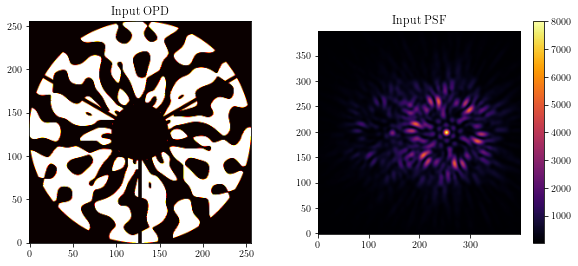

In [3]:
aperture = model.aperture.transmission
mask = model.pupil.get_binary_phase()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(aperture * mask, cmap='hot')
plt.title('Input OPD')

plt.subplot(1, 2, 2)
psf = model.model()
plt.imshow(psf)
plt.colorbar()
plt.title('Input PSF')
plt.show()

In [ ]:
# have to define the loglikelihood function
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()



In [9]:
# Marginal params
shape_dict = {'wavelengths': (1,)}
marginal_params = ['separation', 'contrast', 'position_angle', 'wavelengths', 
    'psf_pixel_scale', 'aperture.coefficients']

# Loss function
opt_param = 'pupil.coefficients'
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_param)
def fim_loss_func(model, parameters):
    #updating this to work for us
    # define a new field 'data'
    # this is basically like taking the expected value
    data = model.model()
    cov = zdx.covariance_matrix(model, parameters, poiss_loglike, 
        shape_dict=shape_dict, data=data)
    return zdx.calc_entropy(cov)

In [10]:
%%time
loss, grads = fim_loss_func(model, marginal_params)
print("Initial Loss: {}".format(loss))

Initial Loss: -208.30484590699078
CPU times: user 1min 20s, sys: 6.57 s, total: 1min 27s
Wall time: 18.1 s


In [11]:
optim, opt_state = zdx.get_optimiser(model, opt_param, optax.adam(2e1))

losses, models_out = [], [model]
with tqdm(range(50),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = fim_loss_func(model, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.3f}".format(loss)) # update the progress bar

Gradient Descent:   0%|          | 0/50 [00:00<?, ?it/s]

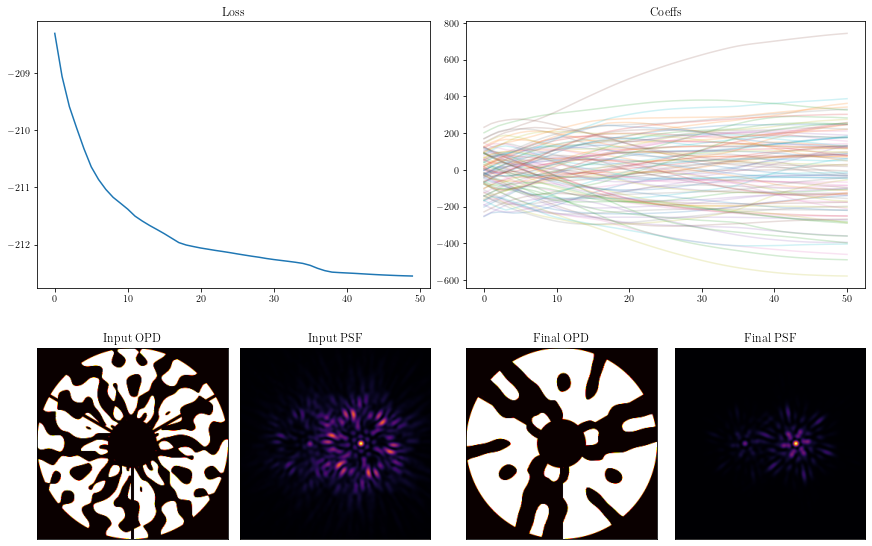

In [12]:
coeffs_out = np.array([model.get(opt_param) for model in models_out])

mosaic = """
         AABB
         CDEF
         """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['C','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])


axes['A'].plot(np.array(losses))
axes['A'].set_title("Loss")

axes['B'].set_title("Coeffs")
axes['B'].plot(coeffs_out[:], alpha=0.2)

mask = models_out[0].pupil.get_binary_phase()
axes['C'].imshow(aperture * mask, cmap='hot')
axes['C'].set_title('Input OPD')

psf_in = models_out[0].model()
axes['D'].imshow(psf_in)
axes['D'].set_title('Input PSF')

mask = models_out[-1].pupil.get_binary_phase()
axes['E'].imshow(aperture * mask, cmap='hot')
axes['E'].set_title('Final OPD')

psf_out = models_out[-1].model()
axes['F'].imshow(psf_out)
axes['F'].set_title('Final PSF')

plt.show()

In [15]:
%%time
covs = [zdx.covariance_matrix(model, marginal_params, poiss_loglike, 
        shape_dict=shape_dict, data=model.model()) for model in [models_out[0], models_out[-1]]]

CPU times: user 1min 2s, sys: 5.27 s, total: 1min 7s
Wall time: 12.1 s


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_42309/3151261347.py:2: SyntaxWarning: invalid escape sequence '\p'
  param_names = ["r (asec)", "$\phi (masec)$", '$f_A/f_B$', "$\lambda (nm)$",
/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_42309/3151261347.py:2: SyntaxWarning: invalid escape sequence '\l'
  param_names = ["r (asec)", "$\phi (masec)$", '$f_A/f_B$', "$\lambda (nm)$",


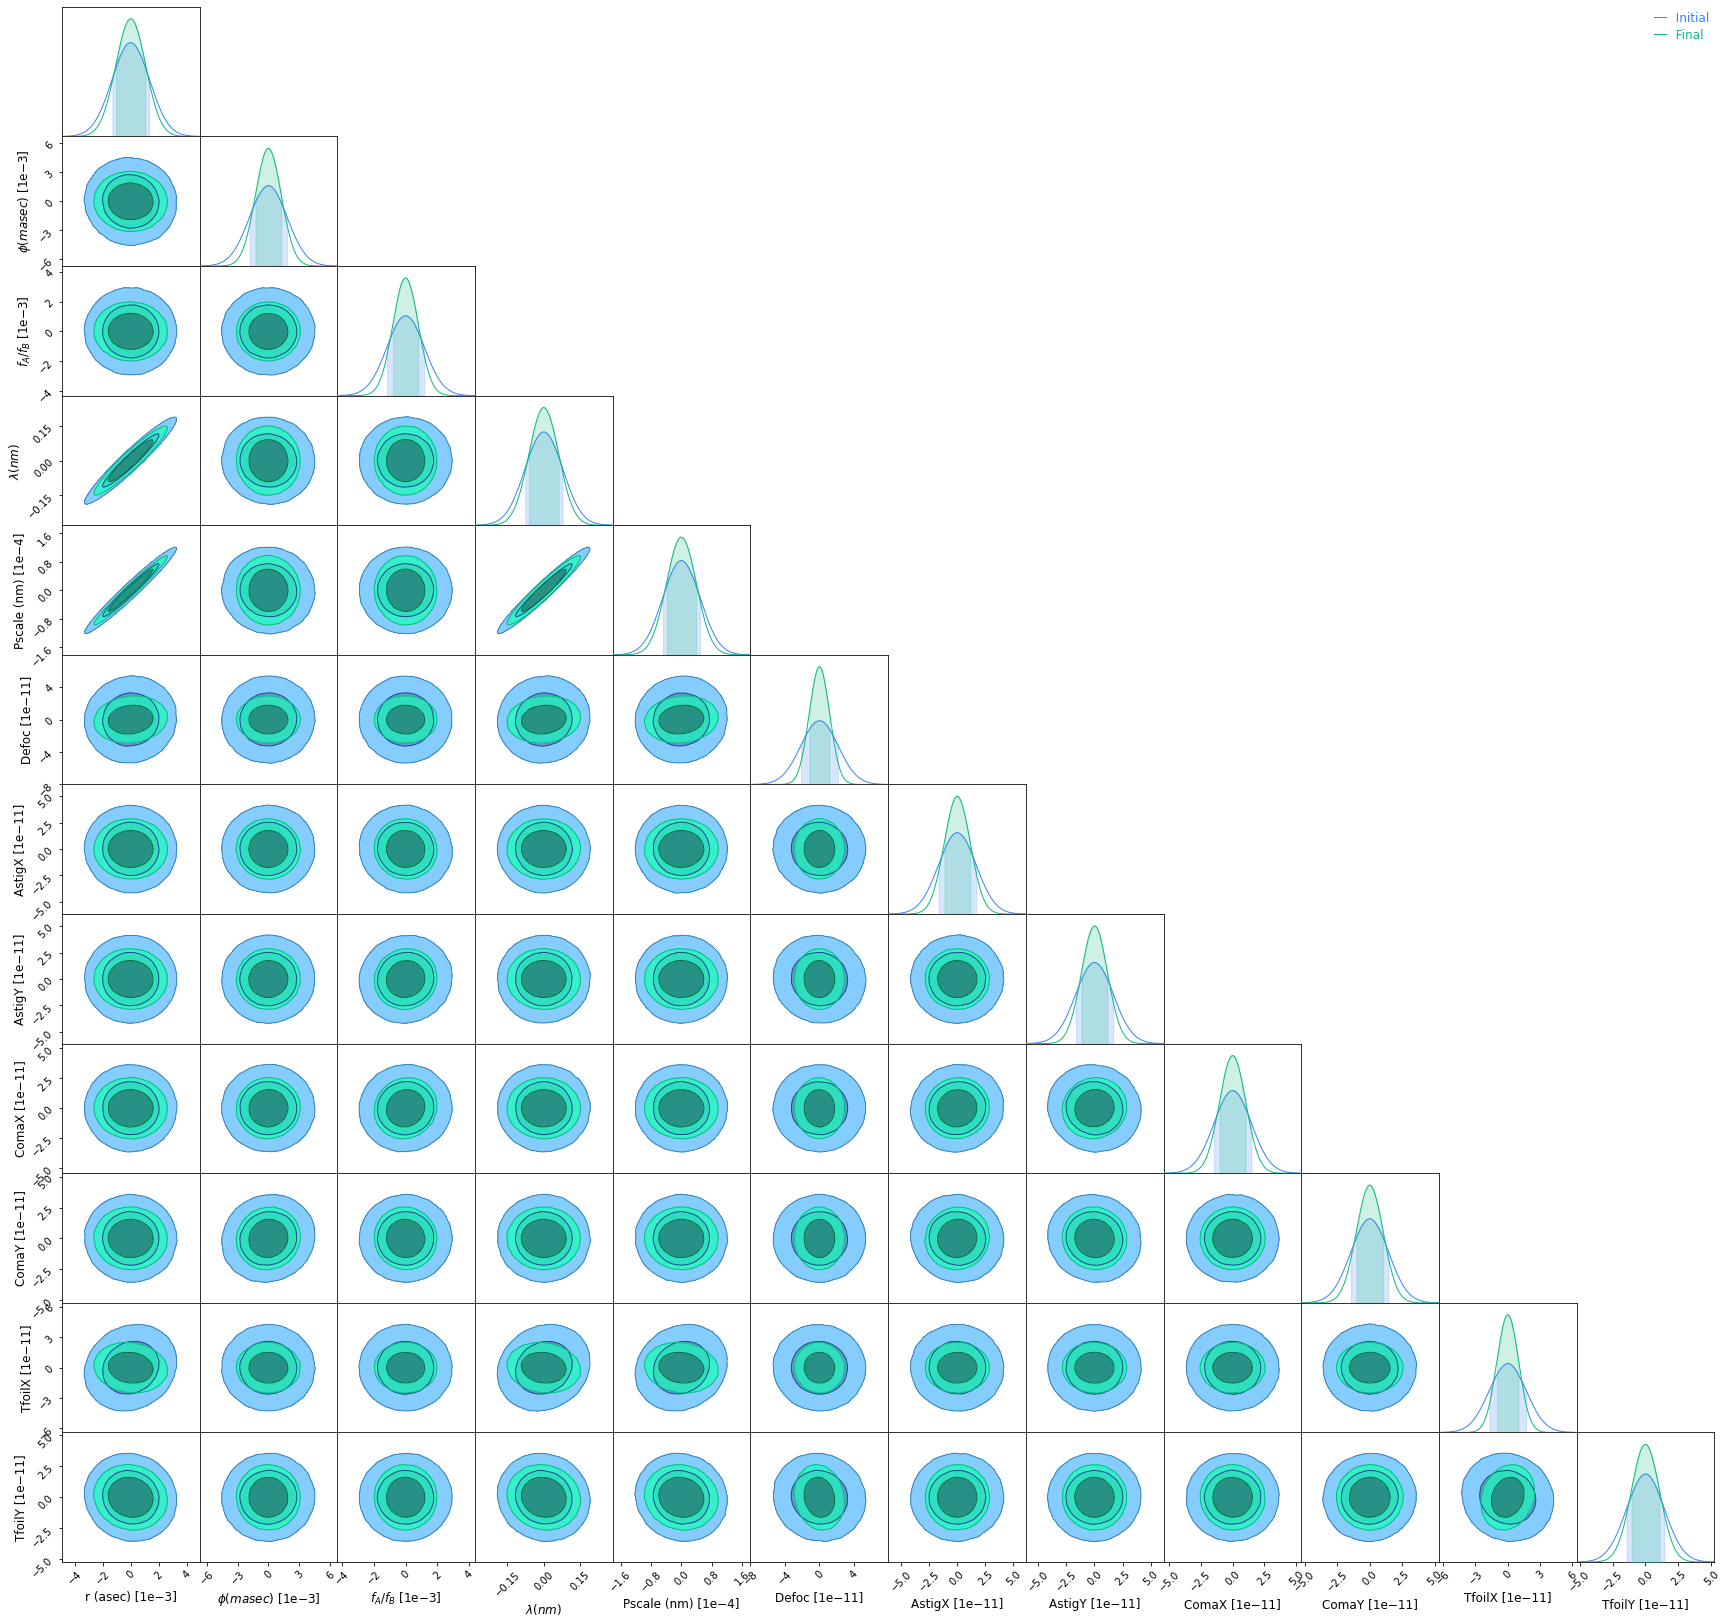

In [ ]:
from chainconsumer import ChainConsumer, Chain
param_names = ["r (asec)", "$\phi (masec)$", '$f_A/f_B$', "$\lambda (nm)$",
               "Pscale (nm)", "Defoc", "AstigX", "AstigY", "ComaX", "ComaY",
               "TfoilX", "TfoilY"]
X = np.zeros(len(param_names))

c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs[0], columns=param_names, name="Initial")
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs[1], columns=param_names, name="Final")
)

#c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()